In [1]:
import sys
sys.path.append('/Users/koush/Projects/Banksy_py')
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from banksy_utils.load_data import load_adata, display_adata

In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [5]:
raw_x, raw_y = adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1]

In [7]:
from banksy.main import median_dist_to_nearest_neighbour

In [8]:
plot_graph_weights = False
k_geom = 15 # number of spatial neighbours
max_m = 1 # use both mean and AFT
nbr_weight_decay = "scaled_gaussian" # can also choose "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours
nbrs = median_dist_to_nearest_neighbour(adata, key = 'spatial')


Median distance to closest cell = 9.999999999999794

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----



In [9]:
adata.obs['x'] = raw_x
adata.obs['y'] = raw_y

In [10]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata,
    ('x', 'y', 'spatial'),
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=False,
    plt_nbr_weights=False,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=False,
)


Median distance to closest cell = 9.999999999999794

---- Ran median_dist_to_nearest_neighbour in 0.01 s ----

---- Ran generate_spatial_distance_graph in 0.06 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.28 s ----

---- Ran generate_spatial_distance_graph in 0.05 s ----

---- Ran theta_from_spatial_graph in 0.04 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.19 s ----



In [11]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
# -----------------------------------------------------
resolutions = [0.6]  # clustering resolution for UMAP
pca_dims = [150]  # Dimensionality in which PCA reduces to
lambda_list = [0.2]  # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m)
# banksy_matrix

Runtime May-20-2025-14-45

3333 genes to be analysed:
Gene List:
Index(['FAM41C', 'PLEKHN1', 'AGRN', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'SCNN1D',
       'ATAD3C', 'SKI', 'PLCH2',
       ...
       'RENBP', 'FLNA', 'PLXNA3', 'GAB3', 'F8', 'F8A1', 'CLIC2', 'IL9R',
       'PCDH11Y', 'NLGN4Y'],
      dtype='object', name='Unnamed: 0', length=3333)

Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <5778x5778 sparse matrix of type '<class 'numpy.float64'>'
	with 86670 stored elements in Compressed Sparse Row format>, 1: <5778x5778 sparse matrix of type '<class 'numpy.complex128'>'
	with 173340 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.13 | Std: 0.29
Size of Nbr | Shape: (5778, 3333)
Top 3 entries of Nbr Mat:

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

AGF matrix | Mean: 0.05 | Std: 0.07
Size of AGF mat (m = 1) | Shape: (5778, 3333)
Top entries of AGF:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Ran 'Create BANKSY Matrix' in 0.08 mins

Cell by gene matrix has shape (

In [ ]:
# from banksy.main import concatenate_all

# banksy_dict["nonspatial"] = {
#     # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
#     0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
# }

# print(banksy_dict['nonspatial'][0.0]['adata'])

In [13]:
from banksy_utils.umap_pca import pca_umap

pca_umap(
    banksy_dict,
    pca_dims = pca_dims,
    add_umap = True,
    plt_remaining_var = False,
)

Current decay types: ['scaled_gaussian']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 150
Original shape of matrix: (5778, 9999)
Reduced shape of matrix: (5778, 150)
------------------------------------------------------------
min_value = -50.35464788303694, mean = 1.2297382065768436e-18, max = 84.11297750843903

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_150_umap"]


/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP embedding
------------------------------------------------------------
shape: (5778, 2)


AxisArrays with keys: reduced_pc_150, reduced_pc_150_umap


In [14]:
from banksy.cluster_methods import run_Leiden_partition

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50, # k_expr: number of neighbours in expression (BANKSY embedding or non-spatial) space
    num_iterations = -1, # run to convergenece
    partition_seed = 42,
    match_labels = True,
)

Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.2
reduced_pc_150 

reduced_pc_150_umap 

PCA dims to analyse: [150]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.2, PCA dimensions = 150)


Nearest-neighbour weighted graph (dtype: float64, shape: (5778, 5778)) has 288900 nonzero entries.
---- Ran find_nn in 3.89 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (5778, 5778)) has 288900 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 6090664 to 286517.


Shared nearest-neighbour (connections only) graph (dtype: int16, shape: (5778, 5778)) has 268978 nonzero entries.

Shared nearest-neighbour (number of shared neighbours as weights) graph (dtype: int16, shape: (5778, 5778)) has 268978 nonzero entries.

sNN graph data:
[17 16 12 ...  8  5  5]

---- Ran shared_nn in 0.26 s ----


-- Multiplying sNN connectivity by weights --


shared 

/Users/koush/Projects/Banksy_py/banksy/labels.py:398: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expand_labels(label_list[sort_indices[0]],


decay  lambda_param  num_pcs  \
scaled_gaussian_pc150_nc0.20_r0.60  scaled_gaussian           0.2      150   

                                    resolution  num_labels  \
scaled_gaussian_pc150_nc0.20_r0.60         0.6           7   

                                                                               labels  \
scaled_gaussian_pc150_nc0.20_r0.60  Label object:\nNumber of labels: 7, number of ...   

                                                                                adata  \
scaled_gaussian_pc150_nc0.20_r0.60  [[[View of AnnData object with n_obs × n_vars ...   

                                                                            relabeled  
scaled_gaussian_pc150_nc0.20_r0.60  Label object:\nNumber of labels: 7, number of ...

number of labels: 7
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 7
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 7
---- Ran plot_2d_embeddings in 0.00 s ----

---- Ran row_normalize in 0.00 s ----


matrix multiplying labels x weights x labels-transpose ((7, 5778) x (5778, 5778) x (5778, 7))



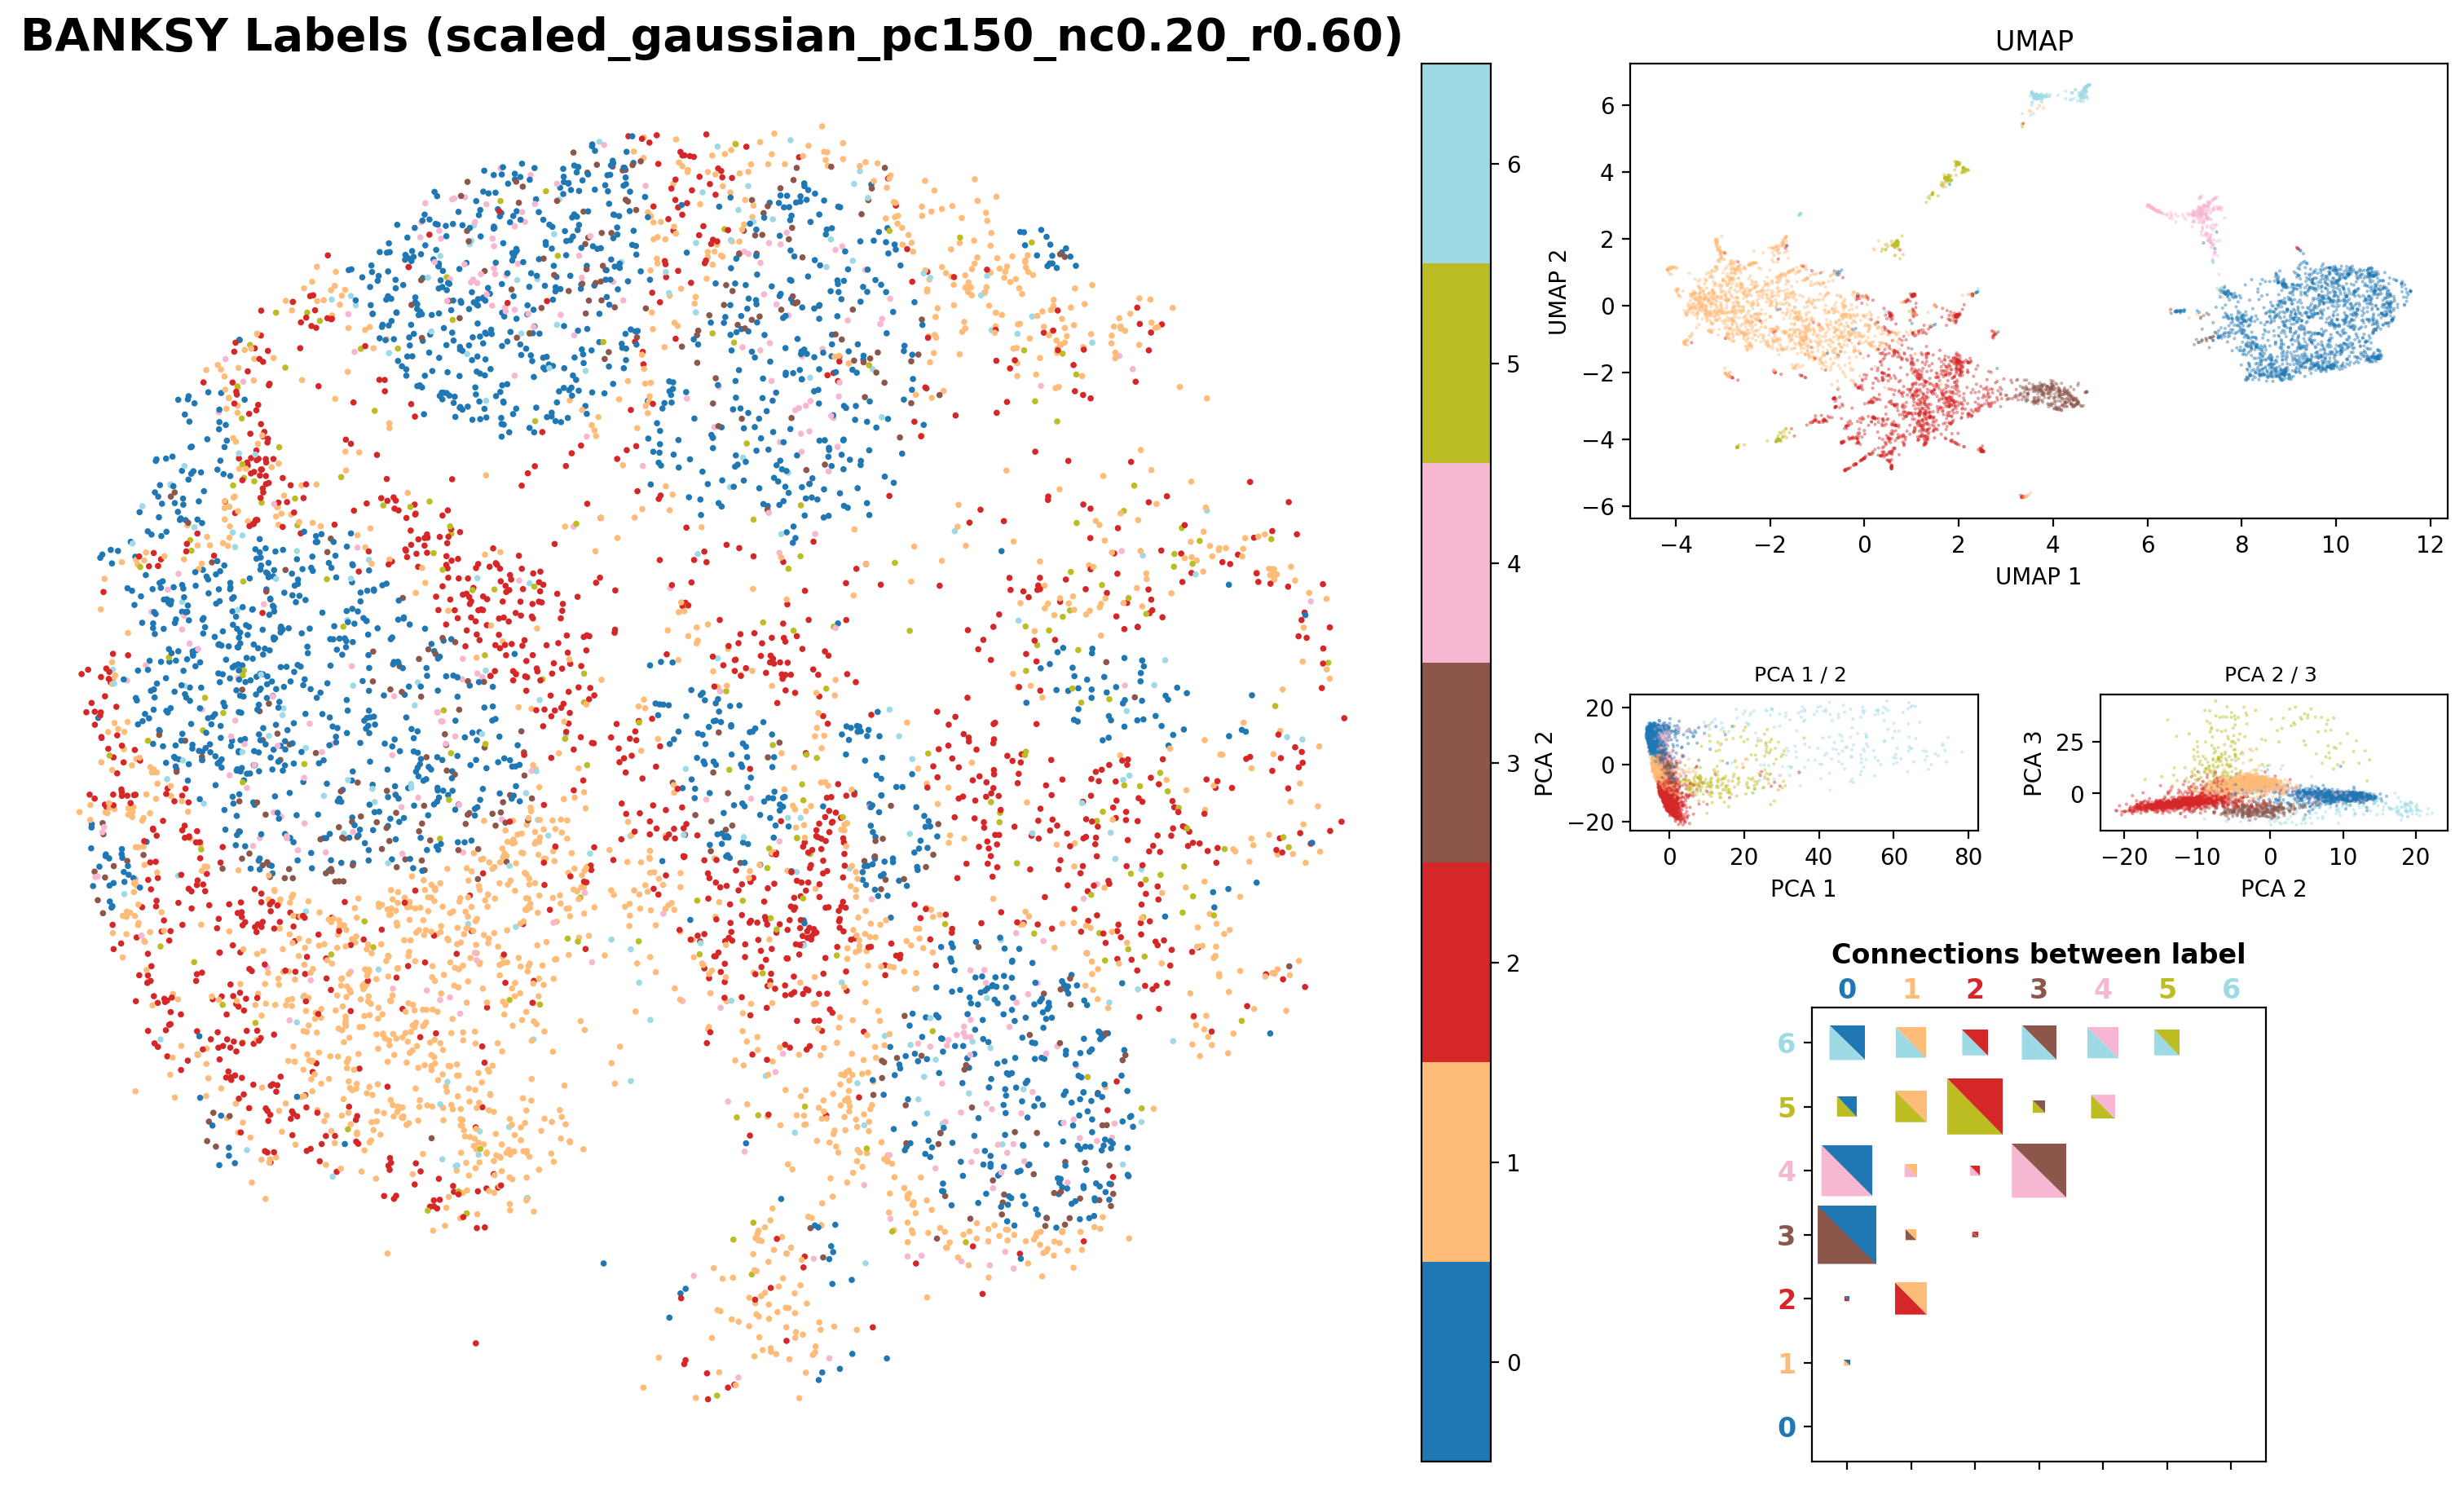

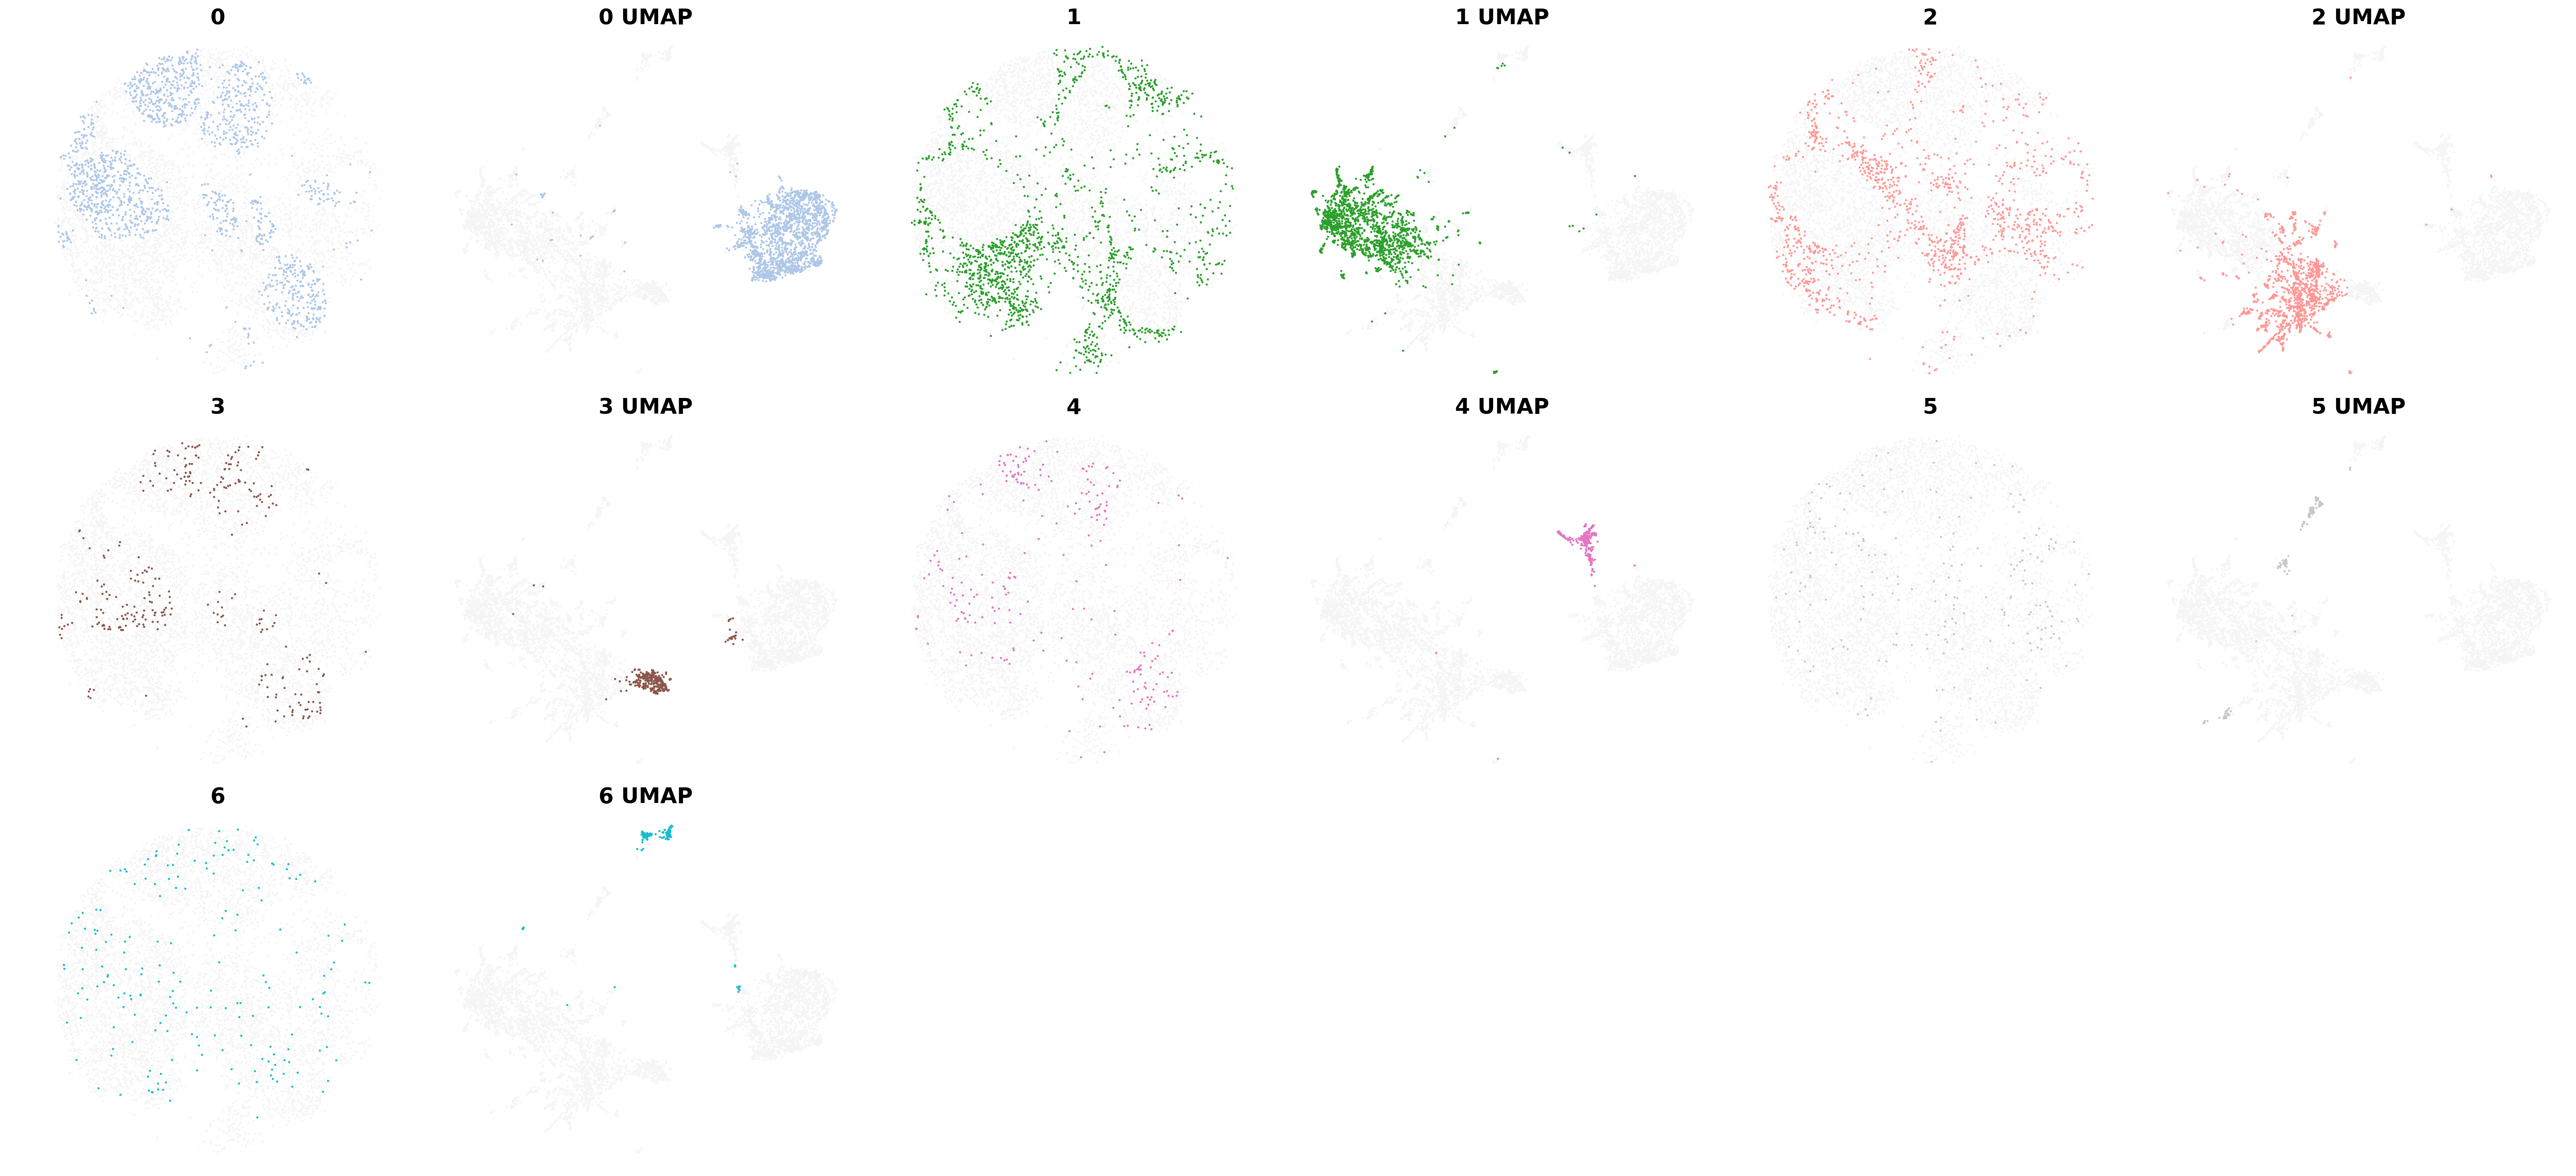

In [15]:
from banksy.plot_banksy import plot_results

c_map =  'tab20' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = ('x', 'y', 'spatial'),
    max_num_labels  =  max_num_labels, 
    save_path = '/tmp',
    save_fig = False
)

In [18]:
results_df.adata[0]

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_36195/1945284084.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.adata[0]


AnnData object with n_obs × n_vars = 5778 × 9999
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'x', 'y', 'labels_scaled_gaussian_pc150_nc0.20_r0.60'
    var: 'is_nbr', 'k'
    obsm: 'reduced_pc_150', 'reduced_pc_150_umap', 'spatial'

In [19]:
atmp = results_df.adata[0].copy()
atmp

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_36195/423117394.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  atmp = results_df.adata[0].copy()


AnnData object with n_obs × n_vars = 5778 × 9999
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'x', 'y', 'labels_scaled_gaussian_pc150_nc0.20_r0.60'
    var: 'is_nbr', 'k'
    obsm: 'reduced_pc_150', 'reduced_pc_150_umap', 'spatial'

In [21]:
atmp.obsm['X_umap'] = atmp.obsm['reduced_pc_150_umap']

In [31]:
atmp.obs = atmp.obs.join(pd.read_csv('tonsil_cell_types.csv', index_col=0))

In [34]:
atmp.obs.cell_type_2.value_counts()

cell_type_2
B_naive                 1088
GC Light Zone            735
GC Dark Zone             558
B_memory                 522
GC Intermediate Zone     467
T_follicular_helper      300
FDC                      288
plasma                   283
T memory                 264
T_CD8                    244
Treg                     198
Naive CD4 T              177
NK                       170
mDC                      137
myeloid                  102
Th1                       88
pDC                       64
Th2                       47
T_double_neg              46
Name: count, dtype: int64

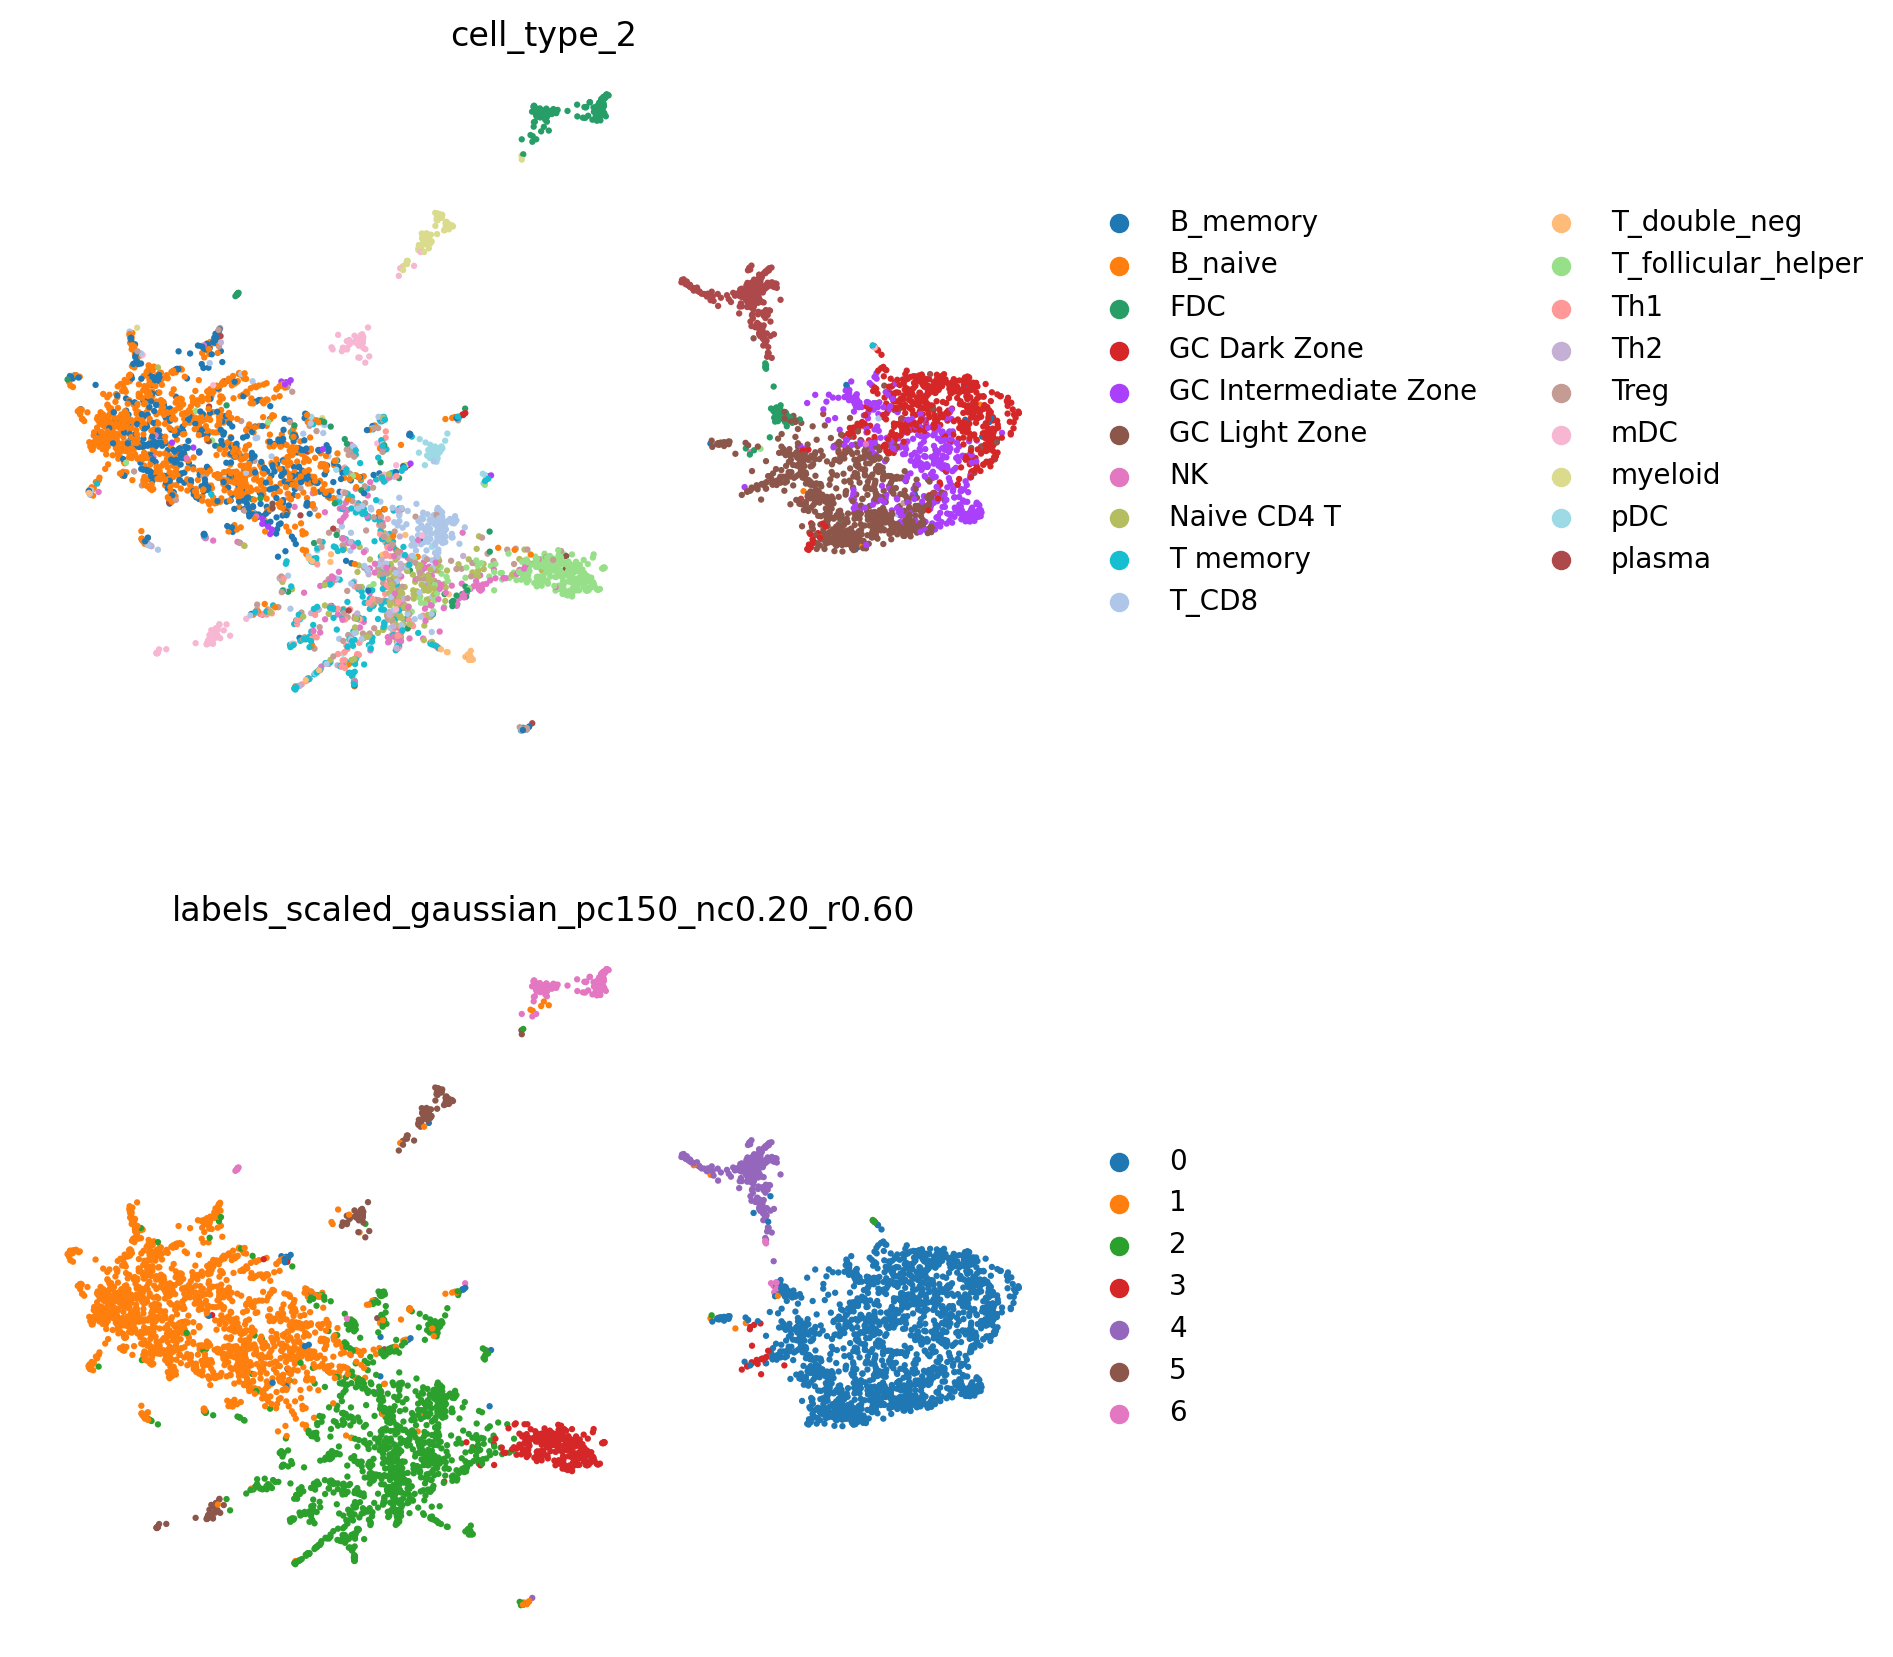

In [35]:
sc.pl.umap(atmp, 
    frameon=False, color=['cell_type_2', 'labels_scaled_gaussian_pc150_nc0.20_r0.60'], 
    add_outline=False, ncols=1,
)

In [48]:
results_df.adata[1].obs['banksy_cluster'] = results_df.adata[1].obs['labels_scaled_gaussian_pc50_nc0.20_r0.60']

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_46782/228181958.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.adata[1].obs['banksy_cluster'] = results_df.adata[1].obs['labels_scaled_gaussian_pc50_nc0.20_r0.60']


In [50]:
pd.DataFrame(results_df.adata[1].obsm['reduced_pc_50_umap'], index=results_df.adata[1].obs_names).join(
    results_df.adata[1].obs['banksy_cluster']
).to_csv('banksy_cluster.csv')

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_46782/2914180170.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame(results_df.adata[1].obsm['reduced_pc_50_umap'], index=results_df.adata[1].obs_names).join(
/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_46782/2914180170.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.adata[1].obs['banksy_cluster']


In [23]:
results_df.adata[1].obs

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_43454/402234810.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.adata[1].obs


cell_type cell_type_int            x            y  \
AAAAAAAAAAAATC       Resting T            12 -3191.440751  3648.762827   
AAAAAAAACCAACA               B             0 -1895.040618  4454.474037   
AAAAAAAGCCAACA               B             0 -1231.629195  3124.707058   
AAAAAAATTTAGGG   B | Resting T             3 -2207.315048  4138.764785   
AAAAAACGGTAGAT   B | Resting T             3 -4172.818596  2577.294496   
...                        ...           ...          ...          ...   
TTTTTTGTTTTCTA       Resting T            12 -1987.780824  2298.681326   
TTTTTTTATGGTAC   B | Resting T             3 -2582.299523  2644.028189   
TTTTTTTGTCGCCT       Resting T            12 -1910.350113  1132.706308   
TTTTTTTTGCTTTA  Resting T | DC            14 -4215.606670  2467.969004   
TTTTTTTTTAGCTC               B             0 -2421.647970  3927.964823   

               labels_scaled_gaussian_pc50_nc0.20_r0.60  
AAAAAAAAAAAATC                                        2  
AAAAAAAACCAACA                                        5  
AAAAAAAGCCAACA                                        3  
AAAAAAATTTAGGG                                        2  
AAAAAACGGTAGAT                                        5  
...                                                 ...  
TTTTTTGTTTTCTA                                        0  
TTTTTTTATGGTAC                                        0  
TTTTTTTGTCGCCT                                        1  
TTTTTTTTGCTTTA                                        5  
TTTTTTTTTAGCTC                                        2  

[24617 rows x 5 columns]

In [28]:
results_df.adata[0].obs

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_43454/926760855.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.adata[0].obs


cell_type cell_type_int            x            y  \
AAAAAAAAAAAATC       Resting T            12 -3191.440751  3648.762827   
AAAAAAAACCAACA               B             0 -1895.040618  4454.474037   
AAAAAAAGCCAACA               B             0 -1231.629195  3124.707058   
AAAAAAATTTAGGG   B | Resting T             3 -2207.315048  4138.764785   
AAAAAACGGTAGAT   B | Resting T             3 -4172.818596  2577.294496   
...                        ...           ...          ...          ...   
TTTTTTGTTTTCTA       Resting T            12 -1987.780824  2298.681326   
TTTTTTTATGGTAC   B | Resting T             3 -2582.299523  2644.028189   
TTTTTTTGTCGCCT       Resting T            12 -1910.350113  1132.706308   
TTTTTTTTGCTTTA  Resting T | DC            14 -4215.606670  2467.969004   
TTTTTTTTTAGCTC               B             0 -2421.647970  3927.964823   

               labels_nonspatial_pc50_nc0.00_r0.60  
AAAAAAAAAAAATC                                   1  
AAAAAAAACCAACA                                   1  
AAAAAAAGCCAACA                                   3  
AAAAAAATTTAGGG                                   0  
AAAAAACGGTAGAT                                   5  
...                                            ...  
TTTTTTGTTTTCTA                                   0  
TTTTTTTATGGTAC                                   2  
TTTTTTTGTCGCCT                                   0  
TTTTTTTTGCTTTA                                   5  
TTTTTTTTTAGCTC                                   0  

[24617 rows x 5 columns]

In [29]:
adata.obs['banksy_spatial'] = results_df.adata[1].obs['labels_scaled_gaussian_pc50_nc0.20_r0.60'].copy()
adata.obs['banksy_nonspatial'] = results_df.adata[0].obs['labels_nonspatial_pc50_nc0.00_r0.60'].copy()

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_43454/2311569122.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs['banksy_spatial'] = results_df.adata[1].obs['labels_scaled_gaussian_pc50_nc0.20_r0.60'].copy()
/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_43454/2311569122.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obs['banksy_nonspatial'] = results_df.adata[0].obs['labels_nonspatial_pc50_nc0.00_r0.60'].copy()


In [34]:
results_df.adata[0]

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_43454/1945284084.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df.adata[0]


AnnData object with n_obs × n_vars = 24617 × 3604
    obs: 'cell_type', 'cell_type_int', 'x', 'y', 'labels_nonspatial_pc50_nc0.00_r0.60'
    var: 'is_nbr', 'k'
    obsm: 'reduced_pc_50', 'reduced_pc_50_umap', 'spatial'

In [35]:
adata.obsm['banksy_spatial_umap'] = results_df.adata[1].obsm['reduced_pc_50_umap']
adata.obsm['banksy_nonspatial_umap'] = results_df.adata[0].obsm['reduced_pc_50_umap']

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_43454/2458082713.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obsm['banksy_spatial_umap'] = results_df.adata[1].obsm['reduced_pc_50_umap']
/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_43454/2458082713.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata.obsm['banksy_nonspatial_umap'] = results_df.adata[0].obsm['reduced_pc_50_umap']


In [36]:
adata.write_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')

In [17]:
label = 'labels_scaled_gaussian_pc50_nc0.20_r1.50'

In [18]:
adata.obs['banksy_cluster'] = results_df.iloc[0].adata.obs.loc[adata.obs_names][label].copy()

KeyError: 'labels_scaled_gaussian_pc50_nc0.20_r1.50'

In [59]:
adata.obs

cell_type cell_type_int            x            y  \
NAME                                                                            
AAACCCAAGCGCCTTG-1              T_CD4             5  1733.213235  1665.039824   
AAACCCAAGTGGACGT-1             plasma            12   519.377858  2220.266321   
AAACCCACAGAAGTGC-1  B_germinal_center             0  1064.296595  2158.266703   
AAACCCAGTCATTGCA-1            B_naive             2  1740.127314  3218.472808   
AAACCCATCATCGCAA-1           B_memory             1   930.600158  2892.947737   
...                               ...           ...          ...          ...   
TTTGTTGCAGGGACTA-1  B_germinal_center             0  1699.607471  1920.402412   
TTTGTTGCATTGTAGC-1             plasma            12   688.211974  2794.005768   
TTTGTTGGTACCACGC-1  B_germinal_center             0  1258.258885  2713.702000   
TTTGTTGGTCTGTCCT-1              T_CD4             5  1833.578543  2142.848257   
TTTGTTGTCATGCGGC-1              T_CD4             5  1056.736769  2472.335923   

                   banksy_cluster  
NAME                               
AAACCCAAGCGCCTTG-1              1  
AAACCCAAGTGGACGT-1              5  
AAACCCACAGAAGTGC-1              3  
AAACCCAGTCATTGCA-1              1  
AAACCCATCATCGCAA-1              0  
...                           ...  
TTTGTTGCAGGGACTA-1              3  
TTTGTTGCATTGTAGC-1              5  
TTTGTTGGTACCACGC-1              3  
TTTGTTGGTCTGTCCT-1              1  
TTTGTTGTCATGCGGC-1              1  

[5778 rows x 5 columns]

In [90]:
adata.obs.cell_type.value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

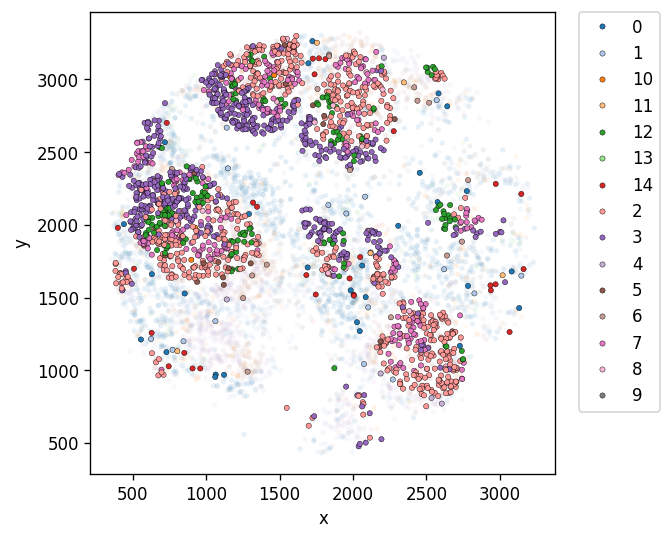

In [126]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 120
label = 'labels_scaled_gaussian_pc50_nc0.20_r0.90'
sns.scatterplot(
    data=adata.obs, 
    x='x', y='y', hue='banksy_cluster', s=10, 
    legend=False, palette='tab20', alpha=0.1)

sns.scatterplot(
    data=adata.obs[adata.obs.cell_type.isin(['B_germinal_center'])], 
    x='x', y='y', hue='banksy_cluster', s=10, linewidth=0.25, edgecolor='black',
    legend=True, palette='tab20')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [81]:
from scipy.stats import chi2_contingency
import numpy as np

In [84]:
# Calculate contingency table and chi-square test for correlation between categorical variables
contingency_table = pd.crosstab(adata.obs['cell_type'], adata.obs['banksy_cluster'])
chi2, p_value = chi2_contingency(contingency_table)[:2]

print("Chi-square test results:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.2e}")

# Calculate Cramer's V correlation coefficient
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramer_v = np.sqrt(chi2 / (n * min_dim))

Chi-square test results:
Chi-square statistic: 37808.61
p-value: 0.00e+00


In [85]:
contingency_table

banksy_cluster         0    1   10   11   12  13  14    2    3    4    5    6  \
cell_type                                                                       
B_germinal_center     28   16    5    6  172   0  28  689  558    5   24   16   
B_memory               6  362    0    0    1   0   0    3    1   71    0   71   
B_naive               23  510    0    1    0   0   0    2    1  311    3  216   
FDC                    4    4  215    1    1   1   0    2    0    4    3    2   
NK                   148    2    0    5    0   0   0    1    0    1   13    0   
T_CD4                744    3    0    6    0   0   0    0    0    0   22    4   
T_CD8                 52    6    0  178    0   0   0    0    0    0    0    2   
T_double_neg          45    0    0    0    0   0   0    0    0    0    0    1   
T_follicular_helper   25    0    0    0    0   0   0    0    0    0  268    1   
mDC                    8    2    0    1    0   0   0    0    0    1    0    1   
myeloid                0    0    0    0    0   0   0    0    0    0    0    2   
pDC                    8    1    0    0    0  54   0    0    0    0    0    1   
plasma                 2    3    0    0    0   0   0    1    0    1    1    1   

banksy_cluster         7    8    9  
cell_type                           
B_germinal_center    280   21    0  
B_memory               1    0    0  
B_naive                0    0    0  
FDC                    0    2   16  
NK                     0    0    0  
T_CD4                  0    0    0  
T_CD8                  0    0    0  
T_double_neg           0    0    0  
T_follicular_helper    0    0    0  
mDC                    0    0  124  
myeloid                0    0  100  
pDC                    0    0    0  
plasma                 2  251    0

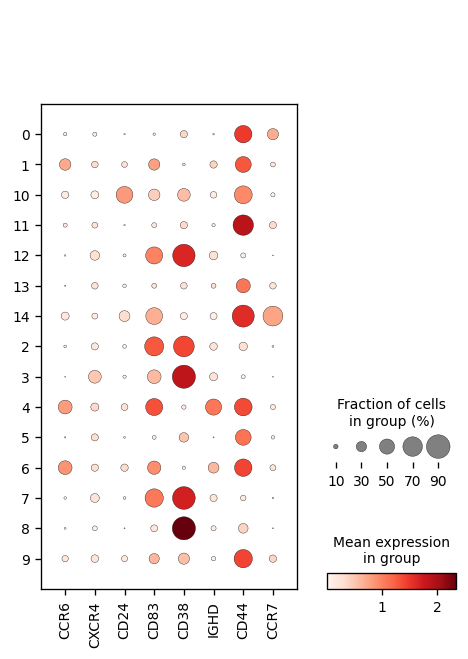

In [116]:
# Get B memory vs B naive cells
b_cells = adata.obs[adata.obs.cell_type.isin(['B_memory', 'B_naive'])]

# Plot marker gene expression
marker_genes = ['CCR6', 'CXCR4','CD24', 'CD83',
    'CD38', 'IGHD', 'CD44', 'CCR7']  # Key marker genes distinguishing memory vs naive B cells

sc.pl.dotplot(adata, marker_genes, groupby='banksy_cluster', dendrogram=False)


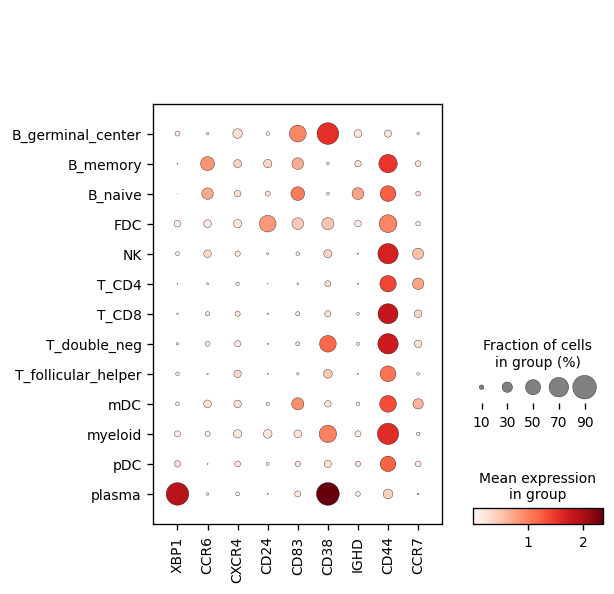

In [124]:
# Get B memory vs B naive cells
b_cells = adata.obs[adata.obs.cell_type.isin(['B_memory', 'B_naive'])]

# Plot marker gene expression
marker_genes = ['XBP1', 'CCR6', 'CXCR4','CD24', 'CD83',
    'CD38', 'IGHD', 'CD44', 'CCR7']  # Key marker genes distinguishing memory vs naive B cells

sc.pl.dotplot(adata, marker_genes, groupby='cell_type', dendrogram=False)


In [128]:
banksy2ct = {
    0: 'T_CD4',
    1: 'B_memory',
    2: 'GC Light Zone',
    3: 'GC Dark Zone',
    4: 'B_naive',
    5: 'T_follicular_helper',
    6: 'B_naive',
    7: 'GC Intermediate Zone',
    8: 'plasma',
    9: 'mDC/myeloid',
    10: 'FDC',
    11: 'T_CD8',
    12: 'GC Intermediate Zone',
    13: 'pDC',
    14: 'GC Light Zone', 
}

In [134]:
adata.obs['banksy_celltypes'] = adata.obs['banksy_cluster'].astype(int).map(banksy2ct)
adata.obs['banksy_celltypes']  = adata.obs['banksy_celltypes'].astype('category')

In [141]:
adata.obs['banksy_celltypes'].unique()

['T_CD4', 'plasma', 'GC Light Zone', 'B_memory', 'GC Intermediate Zone', ..., 'FDC', 'B_naive', 'T_CD8', 'mDC/myeloid', 'pDC']
Length: 12
Categories (12, object): ['B_memory', 'B_naive', 'FDC', 'GC Dark Zone', ..., 'T_follicular_helper', 'mDC/myeloid', 'pDC', 'plasma']

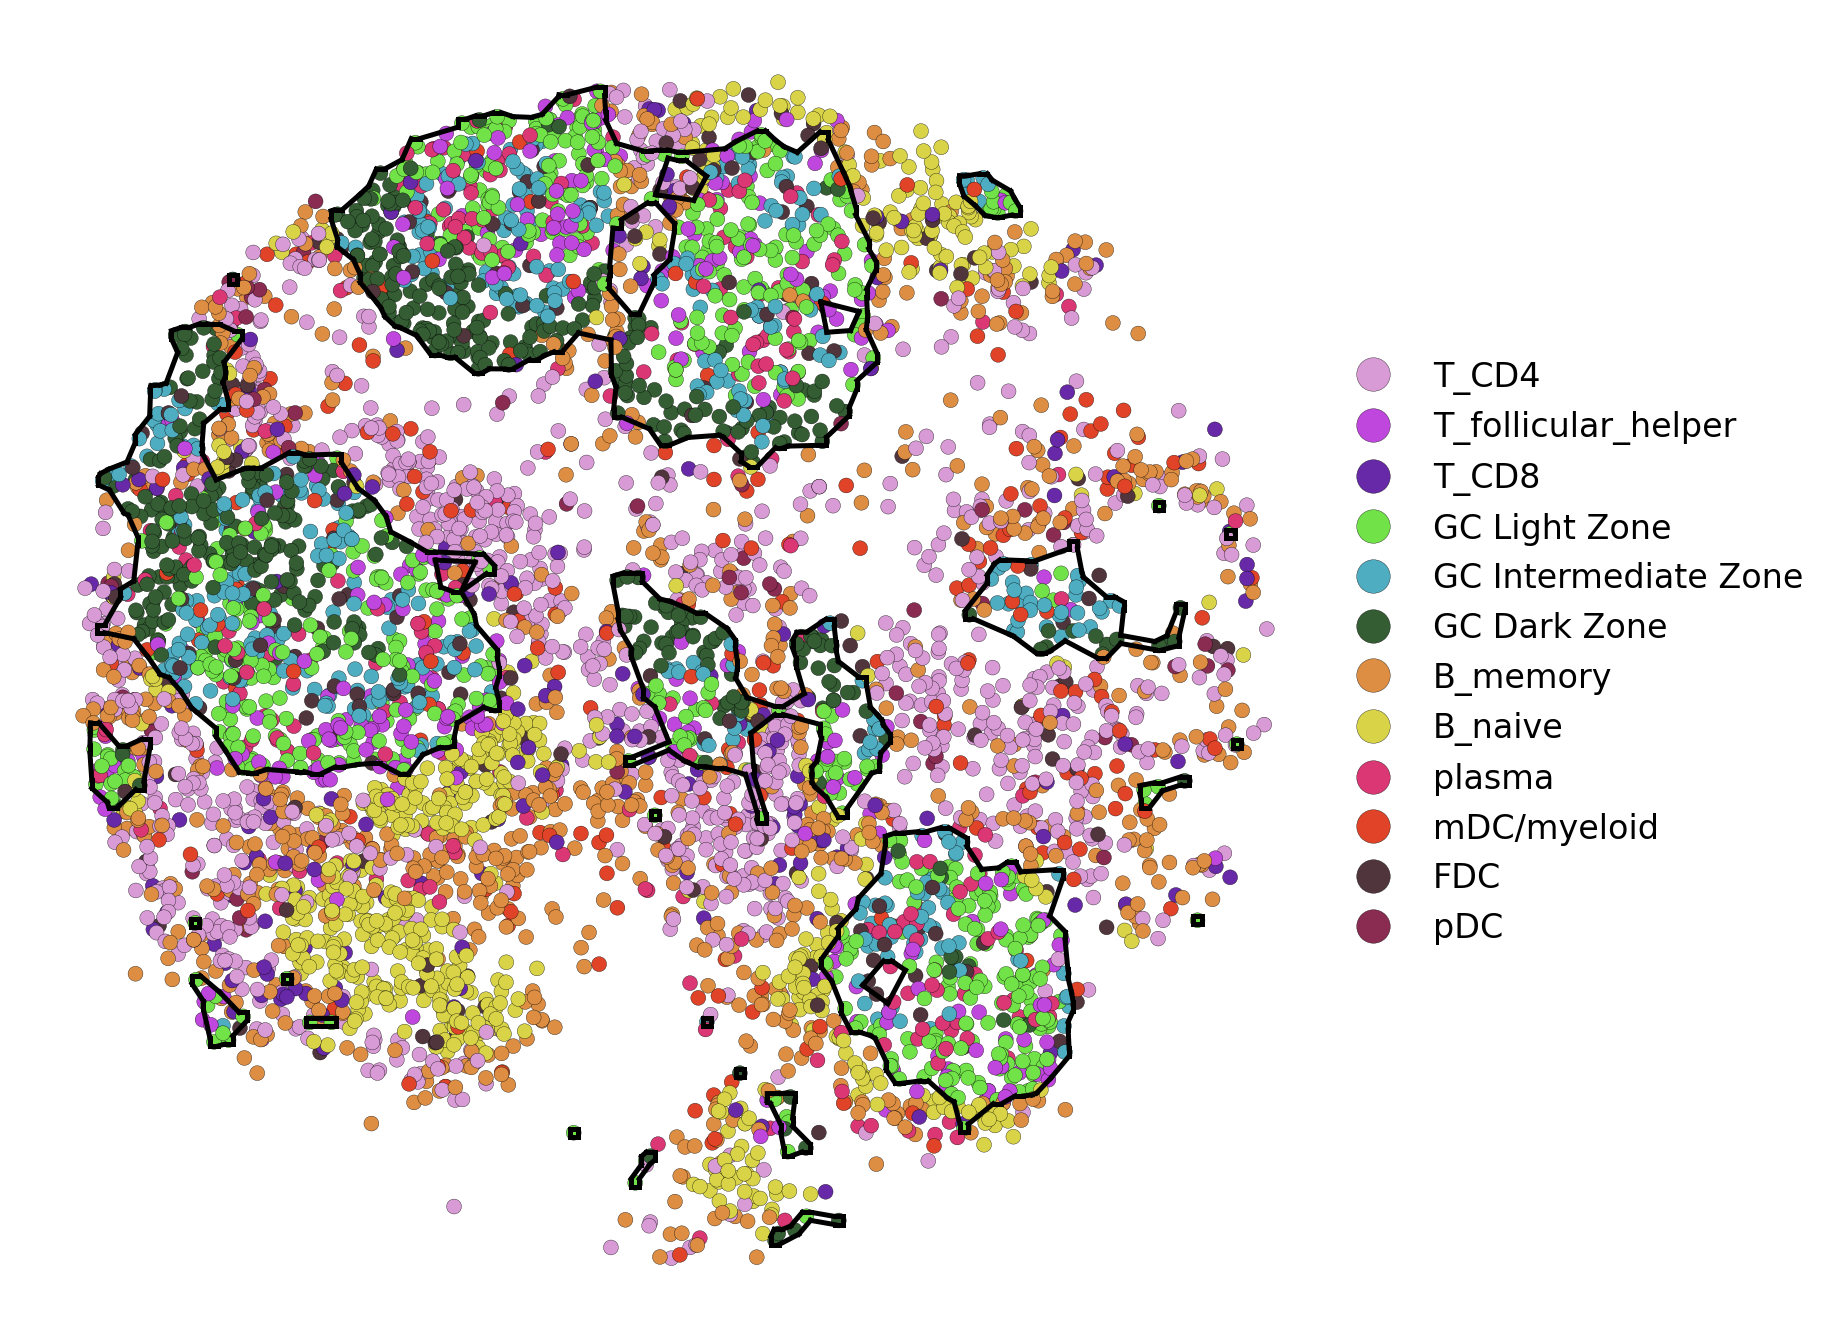

In [216]:
plt.rcParams['figure.figsize'] = (9.25, 9)
plt.rcParams['figure.dpi'] = 120
label = 'labels_scaled_gaussian_pc50_nc0.20_r0.90'

color_dict = {
    'T_CD4': "#d89bd5",
    'T_follicular_helper': "#c047dd", 
    'T_CD8': "#6729a7",
    'GC Light Zone': "#71e248",
    'GC Intermediate Zone': "#4fadc1",
    'GC Dark Zone': "#345d33",
    'B_memory': "#dd8e43",
    'B_naive': "#d9d447", 
    'plasma': "#db3774",
    'mDC/myeloid': "#e04327",
    'FDC': "#50363c",
    'pDC': "#8a2b52"
}
f, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=120)



points = np.asarray(
    adata[adata.obs['banksy_celltypes'].str.contains('GC')].obsm['spatial'])
delta = 10
points = np.vstack(
    (points +[-delta,delta], points +[-delta,-delta], points +[delta,delta], points +[delta,-delta]))

edges = alpha_shape(points, alpha=50, only_outer=True)

for ii, jj in edges:
    ax.plot(points[[ii, jj], 0], points[[ii, jj], 1], 'k', linewidth=1.5)
    
g = sns.scatterplot(
    data=adata.obs, ax=ax,
    x='x', y='y', hue='banksy_celltypes', s=20,
    legend=True, palette=color_dict, alpha=1,
    edgecolor='black', linewidth=0.1, 
    # style='banksy_celltypes'
)


handles, labels = g.get_legend_handles_labels()
label_handle_map = dict(zip(labels, handles))
ordered_handles = [label_handle_map[key] for key in color_dict.keys()]
plt.legend(handles=ordered_handles, labels=color_dict.keys(), 
          bbox_to_anchor=(1, 0.75), loc='upper left',
          borderaxespad=0., frameon=False, fontsize=10, markerscale=2.25)

    
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.show()

In [279]:
adata.obs[['banksy_celltypes']].to_csv('/tmp/banksy_celltypes.csv')

In [232]:
sc.pp.neighbors(adata, use_rep='X')

In [256]:
sc.tl.umap(adata, min_dist=0.5, spread=1)

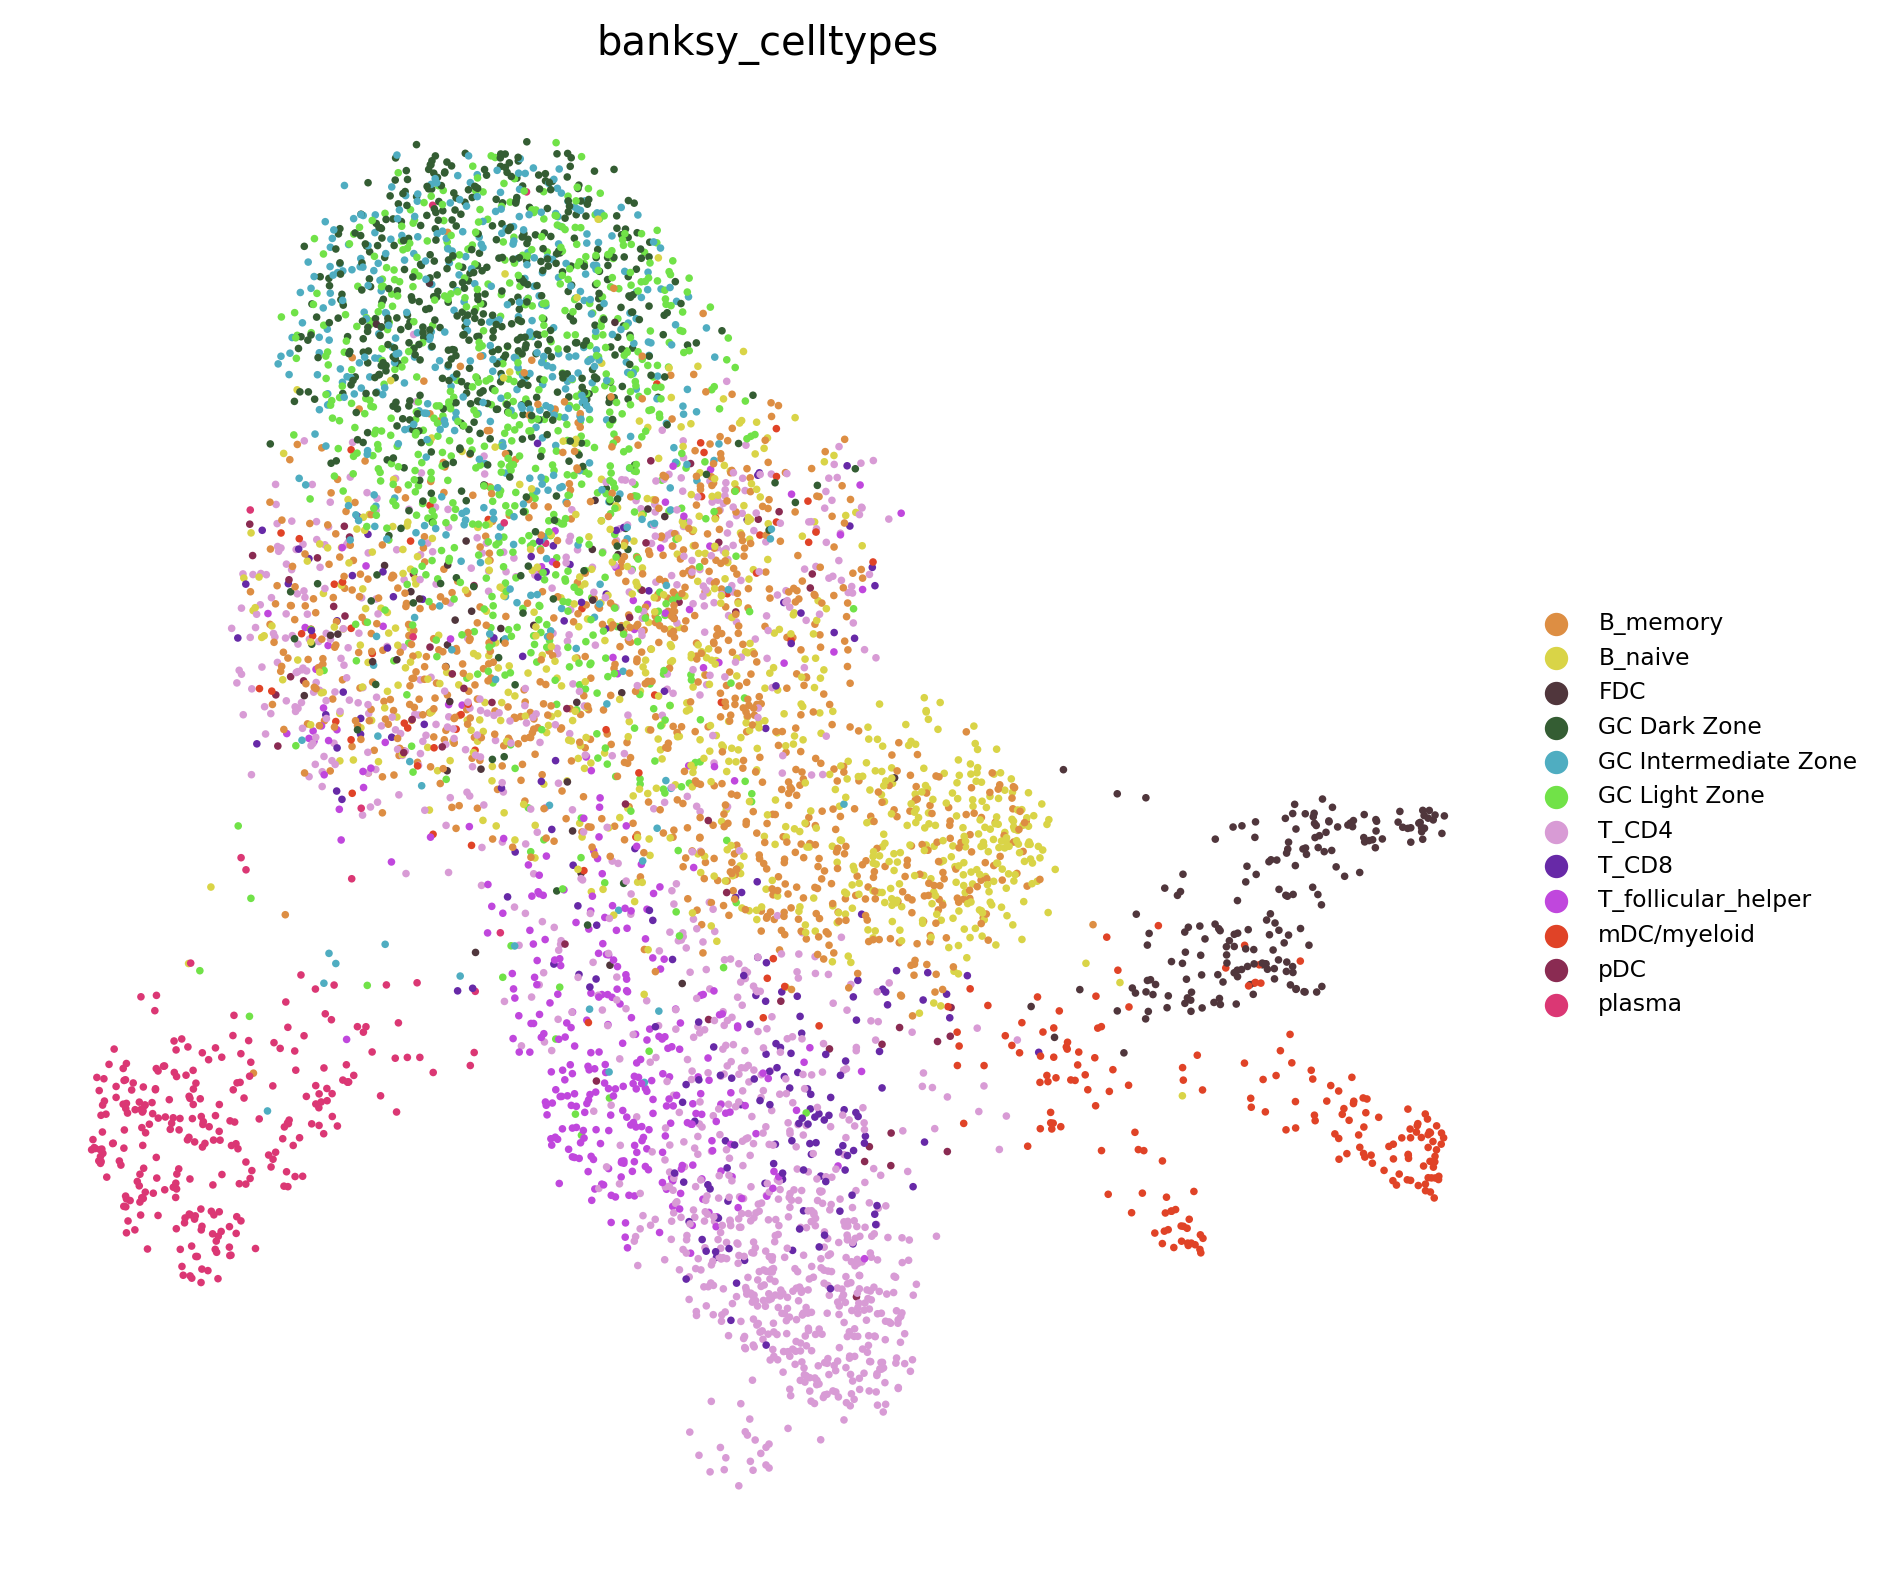

In [276]:
plt.rcParams['figure.figsize'] = (8, 8)
ax = sc.pl.umap(adata, color='banksy_celltypes', 
    legend_fontsize=7, palette=color_dict, frameon=False,
    show=False)